In [1]:
import pandas as pd
import matplotlib.pylab as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split

In [3]:
# Load dataset
df = pd.read_csv('dataset/2015-2024-monthly-tourist-arrivals-sl-csv.csv')
df.head()

,Year,Month,Arrivals,PercentageChange
0,2014,January,146575,6.6
1,2014,February,141878,16.7
2,2014,March,133048,18.0
3,2014,April,112631,8.5
4,2014,May,90046,26.1


In [ ]:
df.drop(df.columns[3], axis=1, inplace=True)
df.head()

In [4]:
# Check for missing values and fill them if necessary
df_v1 = df[['Arrivals']].dropna()

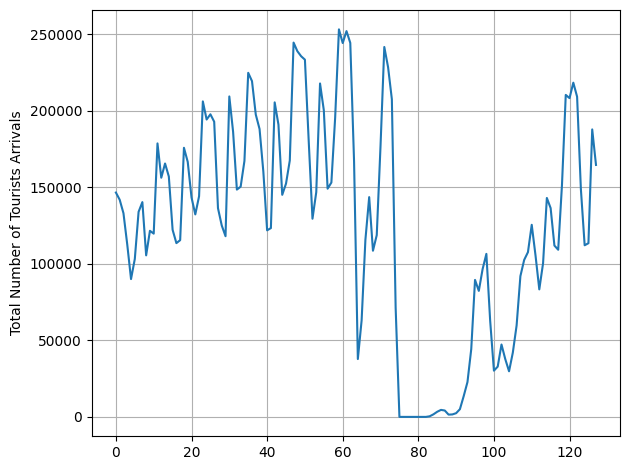

In [5]:
# Plot the time series data to visualize trends
plt.plot(df_v1)
plt.ylabel('Total Number of Tourists Arrivals')
plt.grid()
plt.tight_layout()
plt.show()

In [6]:
# Function to check stationarity with ADF test
def test_stationarity(timeseries):
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value

    print(dfoutput)
    
    critical_value = dftest[4]['5%']
    test_statistic = dftest[0]
    pvalue = dftest[1]
    
    if pvalue < 0.05 and test_statistic < critical_value:
        print("The series is stationary.")
        return True
    else:
        print("The series is not stationary.")
        return False

In [7]:
# Test for stationarity and apply differencing if necessary
time_series_diff = df_v1['Arrivals']
d = 0
while not test_stationarity(time_series_diff):
    time_series_diff = time_series_diff.diff().dropna()
    d += 1

print(f'Differencing order: {d}')

Test Statistic                  -1.818900
p-value                          0.371120
#Lags Used                      12.000000
Number of Observations Used    115.000000
Critical Value (1%)             -3.488535
Critical Value (5%)             -2.887020
Critical Value (10%)            -2.580360
dtype: float64
The series is not stationary.
Test Statistic                  -2.528659
p-value                          0.108656
#Lags Used                      11.000000
Number of Observations Used    115.000000
Critical Value (1%)             -3.488535
Critical Value (5%)             -2.887020
Critical Value (10%)            -2.580360
dtype: float64
The series is not stationary.
Test Statistic                -1.105666e+01
p-value                        4.925472e-20
#Lags Used                     1.000000e+01
Number of Observations Used    1.150000e+02
Critical Value (1%)           -3.488535e+00
Critical Value (5%)           -2.887020e+00
Critical Value (10%)          -2.580360e+00
dtype: float64

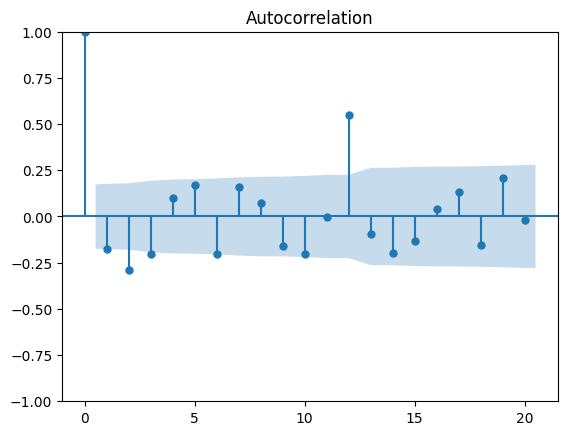

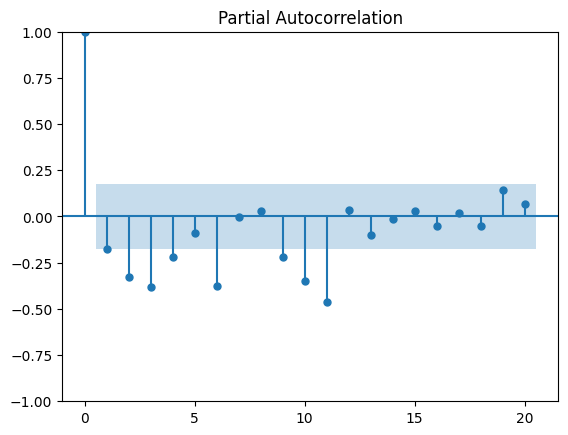

In [8]:
# Plot ACF and PACF to determine p and q
plot_acf(time_series_diff, lags=20)
plt.show()

plot_pacf(time_series_diff, lags=20)
plt.show()

In [9]:
# Split the dataset into train and test sets
train_size = int(len(df_v1) * 0.8)
train, test = df_v1[:train_size], df_v1[train_size:]

In [10]:
# Set SARIMA parameters based on ACF/PACF and seasonality
p, q = 1, 1  # Modify based on your ACF/PACF plots
P, D, Q, m = 1, 0, 1, 12  # Assuming yearly seasonality (m=12)

In [11]:
# Build and fit the SARIMA model
model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, m))
model_fit = model.fit(disp=False)

/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [12]:
# Forecast for the test set
forecast = model_fit.get_forecast(steps=len(test))
predicted_mean = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

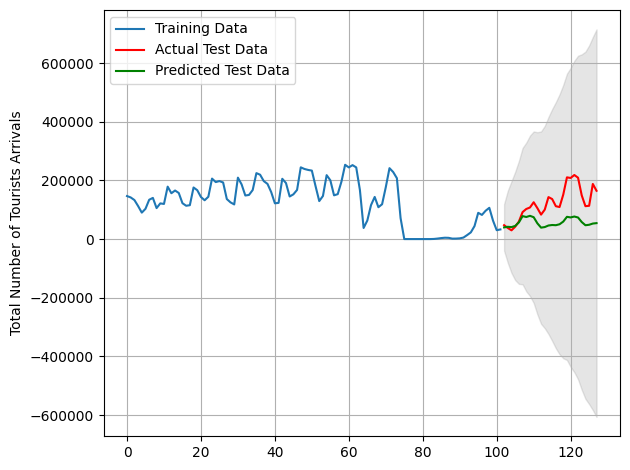

In [13]:
# Plot actual vs predicted with confidence intervals
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual Test Data', color='red')
plt.plot(test.index, predicted_mean, label='Predicted Test Data', color='green')
plt.fill_between(test.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='gray', alpha=0.2)

plt.ylabel('Total Number of Tourists Arrivals')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [14]:
# Print summary of the model
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                           Arrivals   No. Observations:                  102
Model:             SARIMAX(1, 2, 1)x(1, 0, 1, 12)   Log Likelihood               -1184.248
Date:                            Sun, 15 Sep 2024   AIC                           2378.496
Time:                                    07:17:31   BIC                           2391.522
Sample:                                         0   HQIC                          2383.768
                                            - 102                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1630      0.185      0.882      0.378      -0.199       0.525
ma.L1         -0.9894      0.105   